***
## ***Model Selection:***
***

***Prophet Model***    
*In this project, we leveraged the `Prophet` model to predict and analyze time series data.*

In [60]:

import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
import plotly.express as px  
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler

from prophet import Prophet
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:

data = pd.read_csv("../data/feature_and_target_data.csv")
data.head()


DateTime  Zone 1 Power Consumption
0  2017-01-01 00:00:00               34055.69620
1  2017-01-01 01:00:00               25998.98734
2  2017-01-01 02:00:00               23003.54430
3  2017-01-01 03:00:00               21107.84810
4  2017-01-01 04:00:00               20524.55696

In [3]:

data['DateTime'] = pd.to_datetime(data['DateTime'])


*Prophet model will accept column names as `ds` and `y` only. So, we need to rename the columns accordingly.*

In [4]:

data.rename(columns={'DateTime':'ds','Zone 1 Power Consumption':'y'},inplace=True)
data.head()


ds            y
0 2017-01-01 00:00:00  34055.69620
1 2017-01-01 01:00:00  25998.98734
2 2017-01-01 02:00:00  23003.54430
3 2017-01-01 03:00:00  21107.84810
4 2017-01-01 04:00:00  20524.55696

*Given that the data is time series in nature, each observation relies on the preceding ones. As a result, the records cannot be split randomly. Therefore, I am using the first 80% of the data for training and the remaining 20% for testing.*

In [8]:

train_data = data.iloc[:int(data.shape[0]*0.8),:]
test_data = data.iloc[int(data.shape[0]*0.8):,:]  


In [9]:

train_data.shape, test_data.shape


((6988, 2), (1748, 2))

***
## ***Model Training:***
***

*In this step, I initialize the Prophet model by creating an instance of the Prophet class. This sets up the model with default parameters, which can later be customized for trend, seasonality, or holiday effects.*

In [10]:

prophet = Prophet()


In [11]:

prophet.fit(data)


15:11:16 - cmdstanpy - INFO - Chain [1] start processing
15:11:19 - cmdstanpy - INFO - Chain [1] done processing


*I am generating a DataFrame using the `make_future_dataframe` method of the Prophet model. By setting periods=720 and freq='H', I create a time index for the next 720 hours (30 days). The parameter include_history=False ensures that only the future time points are included, excluding the historical data. This will serve as the foundation for making predictions over the specified period*

In [12]:

next_step = prophet.make_future_dataframe(periods=720, freq='H', include_history=False)


*predictions are made on the test dataset using the trained Prophet model.*

In [14]:

forecast = prophet.predict(test_data['ds'].to_frame())


*the trained Prophet model is used to predict future values for unseen data.*

In [15]:

unseen_data = prophet.predict(next_step)


In [16]:

forecast.head()


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2017-10-19 04:00:00  31550.258990  21496.125561  28245.033671  31550.258990   
1 2017-10-19 05:00:00  31548.077979  20571.007916  27212.779090  31548.077979   
2 2017-10-19 06:00:00  31545.896969  19932.744058  26366.959055  31545.896969   
3 2017-10-19 07:00:00  31543.715959  20468.724209  26662.921594  31543.715959   
4 2017-10-19 08:00:00  31541.534949  22128.474271  28711.457887  31541.534949   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  31550.258990    -6608.835122          -6608.835122          -6608.835122   
1  31548.077979    -7796.571357          -7796.571357          -7796.571357   
2  31545.896969    -8519.257591          -8519.257591          -8519.257591   
3  31543.715959    -8028.545980          -8028.545980          -8028.545980   
4  31541.534949    -6128.307661          -6128.307661          -6128.307661   

         daily  daily_lower  daily_upper      weekly  weekly_lower  \
0 -7398.182699 -7398.182699 -7398.182699  789.347576    789.347576   
1 -8571.845113 -8571.845113 -8571.845113  775.273756    775.273756   
2 -9275.991038 -9275.991038 -9275.991038  756.733448    756.733448   
3 -8762.473306 -8762.473306 -8762.473306  733.927326    733.927326   
4 -6835.418857 -6835.418857 -6835.418857  707.111196    707.111196   

   weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    789.347576                   0.0                         0.0   
1    775.273756                   0.0                         0.0   
2    756.733448                   0.0                         0.0   
3    733.927326                   0.0                         0.0   
4    707.111196                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  24941.423867  
1                         0.0  23751.506623  
2                         0.0  23026.639378  
3                         0.0  23515.169979  
4                         0.0  25413.227288

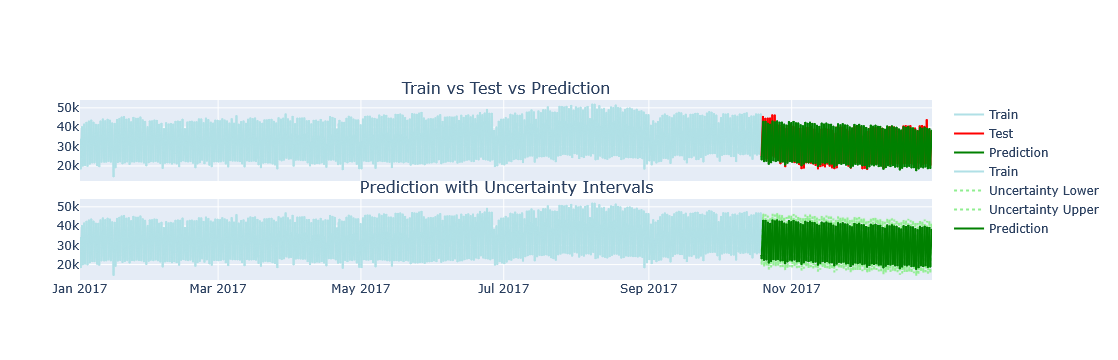

In [17]:


fig = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=True, 
    subplot_titles=("Train vs Test vs Prediction", "Prediction with Uncertainty Intervals"),
    vertical_spacing=0.1
)

fig.add_trace(go.Scatter(x=train_data['ds'], y=train_data['y'], mode='lines', 
                         name='Train', line=dict(color='powderblue')), row=1, col=1)

fig.add_trace(go.Scatter(x=test_data['ds'], y=test_data['y'], mode='lines',  # Fixed test_data
                         name='Test', line=dict(color='red')), row=1, col=1)

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', 
                         name='Prediction', line=dict(color='green')), row=1, col=1)

fig.add_trace(go.Scatter(x=train_data['ds'], y=train_data['y'], mode='lines', 
                         name='Train', line=dict(color='powderblue')), row=2, col=1)

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', 
                         name='Uncertainty Lower', line=dict(color='lightgreen', dash='dot')), row=2, col=1)

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', 
                         name='Uncertainty Upper', line=dict(color='lightgreen', dash='dot')), row=2, col=1)

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', 
                         name='Prediction', line=dict(color='green')), row=2, col=1)  # Fixed incomplete line

fig.show()


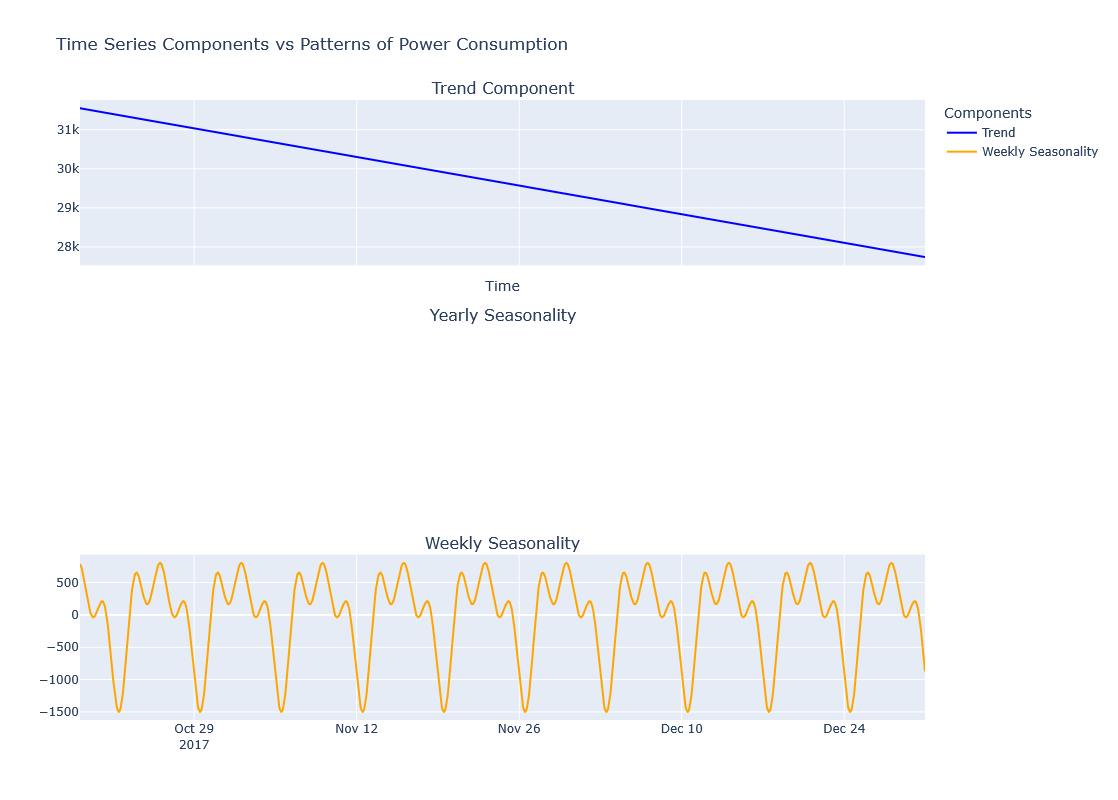

In [18]:

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=("Trend Component", "Yearly Seasonality", "Weekly Seasonality"),
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], mode='lines', 
                         name='Trend', line=dict(color='blue')), row=1, col=1)

if 'yearly' in forecast.columns:
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], mode='lines', 
                             name='Yearly Seasonality', line=dict(color='green')), row=2, col=1)

if 'weekly' in forecast.columns:
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], mode='lines', 
                             name='Weekly Seasonality', line=dict(color='orange')), row=3, col=1)

fig.update_layout(
    title="Time Series Components vs Patterns of Power Consumption",
    height=800,
    xaxis_title="Time",
    legend_title="Components"
)

# Show plot
fig.show()


***1. Trend Component:***
- The trend line (blue) shows a gradual decline in power consumption over time.
- This could indicate a long-term decrease in demand or efficiency improvements in power usage.

***2. Yearly Seasonality:***
- The section for yearly seasonality appears blank, which suggests that either the data doesn't cover a full year or the yearly seasonal component is weak.
- If this is unexpected, it may be due to an issue in the decomposition process.

***3. Weekly Seasonality:***
- The weekly seasonality (orange) exhibits a clear cyclic pattern, with peaks and troughs occurring at regular intervals.
- This suggests a consistent weekly consumption pattern, possibly higher usage on specific days and lower on others.
- Large dips could indicate reduced consumption on weekends or non-working days.
***
***

***LSTM Model***    
*I am leveraging the `Long Short-Term Memory (LSTM)` model for time series forecasting. The LSTM architecture is particularly suited for sequential data as it effectively captures long-term dependencies and patterns. By training the model on historical data, it learns the trends and relationships, which are then used to predict future values.*

$-$    
To ensure better evaluation and fine-tuning of the model, I am splitting the test dataset into two parts: 
- a `train set` (first 50% of the test data for validation (data_val)), and
- a `test set` (remaining 50% for testing (data_test)).


In [19]:

train_set = test_data.iloc[:int(test_data.shape[0]*0.5)]
test_set = test_data.iloc[int(test_data.shape[0]*0.5):]


In [20]:

train_set.shape, test_set.shape


((874, 2), (874, 2))

In [21]:

data_train = train_data.copy()


In [22]:

def data_shifter(data):
    data.set_index('ds',inplace=True)
    for i in range(1,6):
        data[f'y-{i}']=data['y'].shift(i,freq='H')
    return data
    

In [23]:

data_train_featured = data_shifter(data_train).dropna()
train_set_featured = data_shifter(train_set).dropna()
test_set_featured = data_shifter(test_set).dropna()


In [24]:

data_train_featured.shape, train_set_featured.shape, test_set_featured.shape 


((6983, 6), (869, 6), (869, 6))

In [25]:

scaler = MinMaxScaler()

data_train_featured_scaled = scaler.fit_transform(data_train_featured)

train_set_featured_scaled = scaler.transform(train_set_featured)

test_set_featured_scaled = scaler.transform(test_set_featured)


In [27]:

tf.random.set_seed(42)


In [28]:

model = Sequential([
    layers.InputLayer((5,1)),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(128, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1)  # No activation for regression tasks
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [31]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [32]:

model.fit(data_train_featured_scaled[:,1:6], data_train_featured_scaled[:,0],
          validation_data=(train_set_featured_scaled[:,1:6], train_set_featured_scaled[:,0]),
          epochs=15, callbacks=[early_stopping])


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0439 - mae: 0.1562 - val_loss: 0.0076 - val_mae: 0.0666
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0096 - mae: 0.0745 - val_loss: 0.0043 - val_mae: 0.0458
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0073 - mae: 0.0621 - val_loss: 0.0049 - val_mae: 0.0534
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0070 - mae: 0.0605 - val_loss: 0.0046 - val_mae: 0.0509
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0065 - mae: 0.0574 - val_loss: 0.0042 - val_mae: 0.0464
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0062 - mae: 0.0563 - val_loss: 0.0048 - val_mae: 0.0544
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0060 - mae: 0.0555 - val_loss: 0.0039 - val_mae: 0.0428
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0057 - mae: 0.0536 - val_loss: 0.0041 - val_mae: 0.0460
Epoch 9/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms

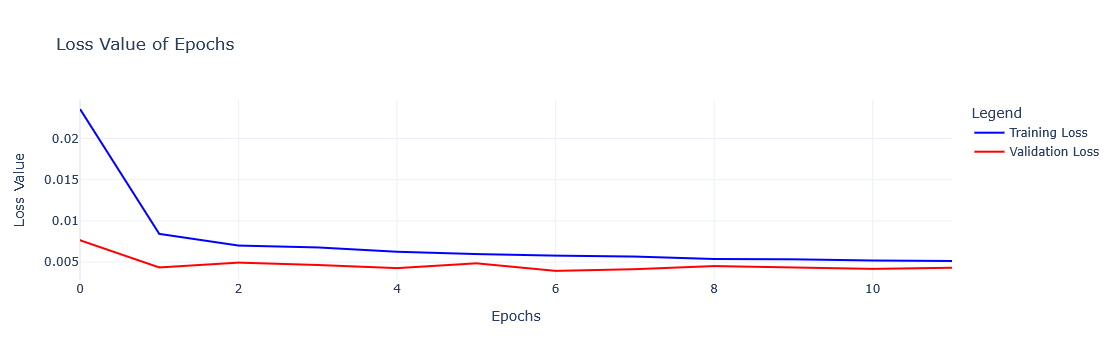

In [33]:

epochs = list(range(len(model.history.history['loss'])))
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=epochs,
    y=training_loss,
    mode='lines',
    name='Training Loss',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=epochs,
    y=validation_loss,
    mode='lines',
    name='Validation Loss',
    line=dict(color='red')
))

fig.update_layout(
    title="Loss Value of Epochs",
    xaxis_title="Epochs",
    yaxis_title="Loss Value",
    legend_title="Legend",
    template="plotly_white"
)

fig.show()


In [34]:

y_predict = model.predict(test_set_featured_scaled[:,1:6],verbose=0)


In [35]:

def inv_transform(data):
    return (data * (scaler.data_max_[0] - scaler.data_min_[0])) + scaler.data_min_[0]
    

In [36]:

y_predict_reversed = inv_transform(y_predict.flatten())

y_reversed=inv_transform(test_set_featured_scaled[:,0])


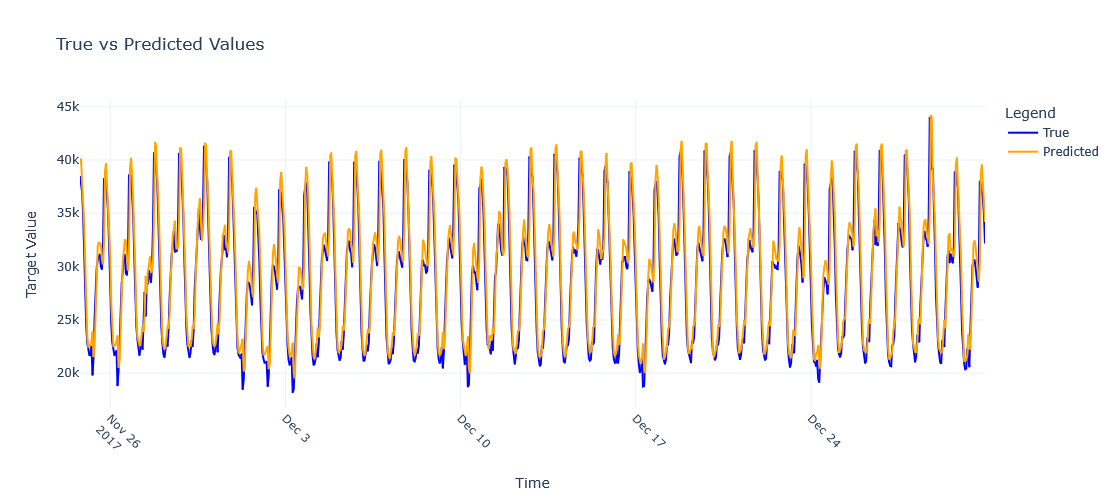

In [45]:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_set_featured.index,
    y=y_reversed,
    mode='lines',
    name='True',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_set_featured.index,
    y=y_predict_reversed,
    mode='lines',
    name='Predicted',
    line=dict(color='orange')
))

fig.update_layout(
    title="True vs Predicted Values",
    xaxis_title="Time",
    yaxis_title="Target Value",
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    legend_title="Legend",
    template="plotly_white",
    height=500,  # Adjust the size if needed
    width=1100
)

fig.show()


In [52]:

def future_predictions(num,start=test_set_featured_scaled[-1,1:6].reshape(1,-1)):
    result=[]
    future_pred=pd.DataFrame()
    
    for i in range(num):
        pred=model.predict(start,verbose=0)[0][0]
        result.append(pred)
        start=start.flatten().tolist()
        future_pred[i]=start
        start.append(pred)
        start.pop(0)
        start=np.array(start).reshape(1,-1)
    
    future_pred=future_pred.T
    future_pred[5]=result
    return future_pred
    

In [56]:

Future_predictions = future_predictions(24)

Future_predictions[5] = inv_transform(Future_predictions[5])

Future_predictions.index = pd.date_range(start = '2017-12-30 23:00:00', periods = 24, freq = 'H')


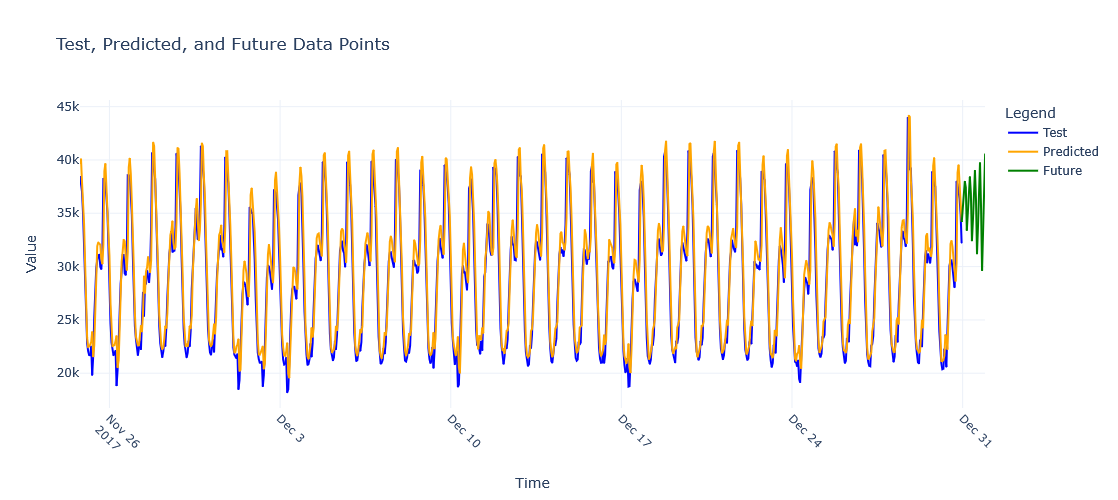

In [59]:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=test_set_featured.index,
    y=y_reversed,
    mode='lines',
    name='Test',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=test_set_featured.index,
    y=y_predict_reversed,
    mode='lines',
    name='Predicted',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=Future_predictions.index,
    y=Future_predictions[5],  # Assuming 'fp[5]' contains the future values
    mode='lines',
    name='Future',
    line=dict(color='green')
))

fig.update_layout(
    title="Test, Predicted, and Future Data Points",
    xaxis_title="Time",
    yaxis_title="Value",
    xaxis=dict(tickangle=45),  
    legend_title="Legend",
    template="plotly_white",
    height=500,
    width=1100
)

fig.show()


***
## ***Model Evaluation:***
***

In [61]:

mape = mean_absolute_percentage_error(test_data['y'], forecast['yhat'])

r2 = r2_score(test_data['y'], forecast['yhat'])

print(f"Prophet Model: \nMean Absolute Percentage Error: {mape:.2%}")
print(f"Accuracy Score (R²): {r2:.2%}")

mae = mean_absolute_error(test_data['y'], forecast['yhat'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Prophet Model: 
Mean Absolute Percentage Error: 6.22%
Accuracy Score (R²): 85.34%
Mean Absolute Error (MAE): 1848.51
